# Machine Learning

## Set up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
df = pd.read_pickle("sample")
# show numerical values
df.describe()

,backers_count,goal,pledged,life,duration,prep
count,231381.000000,2.313810e+05,2.313810e+05,231381,231381,231381
mean,134.295772,4.729175e+04,1.227821e+04,33 days 20:09:57.300962,31 days 10:05:47.950847,42 days 21:29:37.516438
std,1095.131066,1.172776e+06,1.320999e+05,12 days 13:00:42.671194,14 days 07:00:24.493691,110 days 13:02:43.664584
min,0.000000,1.000000e-02,0.000000e+00,1 days 00:00:00,0 days 00:00:00,0 days 00:01:41
25%,2.000000,2.000000e+03,5.000000e+01,30 days 00:00:00,28 days 13:07:40,2 days 17:09:51
50%,19.000000,5.000000e+03,1.035000e+03,30 days 00:00:00,30 days 00:00:01,10 days 01:52:47
75%,74.000000,1.500000e+04,5.405420e+03,35 days 22:27:34,34 days 18:48:37,34 days 10:33:15
max,219382.000000,1.000000e+08,2.902191e+07,91 days 23:00:00,354 days 19:06:23,2313 days 16:40:37


In [105]:
# convert duration data to seconds
df['life_days'] = df['life'].dt.days
df['prep_days'] = df['prep'].dt.days
df['top100'] = df['top100'].fillna(99).astype(int)

In [106]:
# keep only successful / fail projects
# keep only US projects
data = df[(df.location_country =="US") & ((df.state == "successful")|(df.state == "failed"))].reset_index(drop = True)

# keep only numerical/categorical variables
DropCol = ['location_country','location_state','location_localized_name','location_name','cbsa_name','creator_name',
      'category_name','launched_at','deadline','state_changed_at','life','duration','prep','pledged','backers_count']

data = data.drop(DropCol,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159925 entries, 0 to 159924
Data columns (total 8 columns):
top100            159925 non-null int64
goal              159925 non-null float64
gender            159925 non-null object
category_broad    159925 non-null category
state             159925 non-null category
slug              159925 non-null object
life_days         159925 non-null int64
prep_days         159925 non-null int64
dtypes: category(2), float64(1), int64(3), object(2)
memory usage: 7.6+ MB


## Text Analysis 
Structure analysis of headline. Reference: http://nbviewer.jupyter.org/github/AYLIEN/headline_analysis/blob/06f1223012d285412a650c201a19a1c95859dca1/main-chunks.ipynb#A-primer-on-parse-trees

In [3]:
import spacy 
from spacy import displacy
import difflib

EN = spacy.load("en")
nlp = spacy.load('en_core_web_sm')

In [35]:
# test tokens
data.slug.sample(5)

699                                        hotel-chicamauga
72401                          hearts-and-daggers-new-album
153857    help-kickstart-welcome-to-limericks-debut-ep-a...
149150    got-emissions-275-inch-x-9-inch-vinyl-bumper-s...
76986                                     the-warped-vinyls
Name: slug, dtype: object

In [39]:
slugs = [slug for slug in data['slug']]
slugs[1]

'chasing-gold-lined-storms'

In [90]:
def tokenize_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d slugs." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.pos_ for tok in doc]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [96]:
# tokenize all slugs.

slugs_tokenize = tokenize_text(slugs, True)

In [40]:
# slugs_tokenize.to_pickle("slugs_tokenize")
slugs_tokenize = pd.read_pickle("slugs_tokenize")
slugs_tokenize[1]


'VERB PUNCT NOUN PUNCT VERB PUNCT NOUN'

In [4]:
# difference in length and structure sequence
difflib.SequenceMatcher(None,slugs_tokenize[10],slugs_tokenize[2]).ratio()


0.6216216216216216

### Select a random sample randomly to train the classifier
Pair-wise similarity matrix for the headlines

In [23]:
# 1000 training set
np.random.seed(10)
sample_size = 1000
sample_index = np.random.randint(0, len(slugs_tokenize), sample_size)
m = np.zeros((sample_size,sample_size))

for i, slug_x in enumerate(slugs_tokenize[sample_index]):
    for j, slug_y in enumerate(slug_x):
        m[i][j] = difflib.SequenceMatcher(None,slug_x,slug_y).ratio()

In [24]:
m.shape

(1000, 1000)

use tSNE to reduce the dimensionality of similarity matrix from 1000 down to 2:

In [25]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)

In [26]:
tsne = tsne_model.fit_transform(m)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.028s...
[t-SNE] Computed neighbors for 1000 samples in 0.653s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.082664
[t-SNE] Error after 1000 iterations: 0.087015


In [27]:
from sklearn.cluster import MiniBatchKMeans

kmeans_model = MiniBatchKMeans(n_clusters=5, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(m)
kmeans_clusters = kmeans.predict(m)
kmeans_distances = kmeans.transform(m)

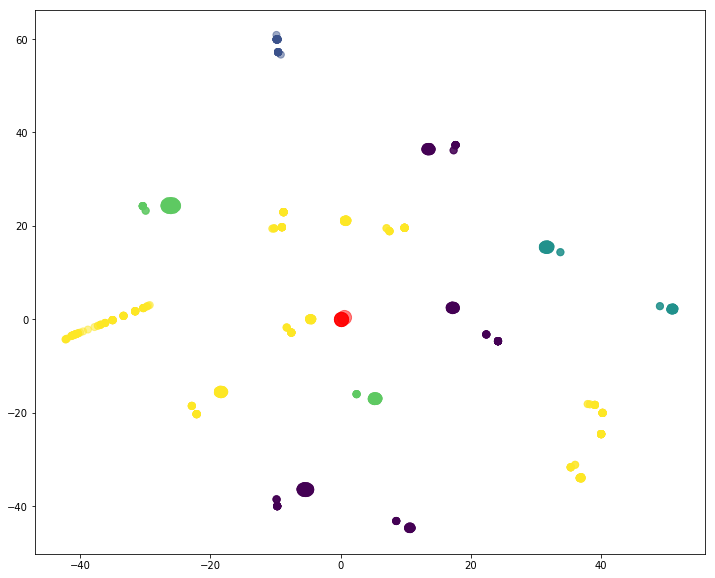

In [28]:
plt.figure(figsize=(12,10))

plt.scatter(tsne[:, 0], tsne[:, 1], c=kmeans_clusters, s=50, cmap='viridis' ,alpha =0.5)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,  alpha=0.5)


## Remove Outliers

In [136]:
CatCol = ['gender','top100','category_broad']
NumCol = ['goal','life_days','prep_days']

In [108]:
import collections
c = collections.Counter()

for feature in NumCol:
    
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    
    step = 1.5 * (Q3 - Q1)
    
    outlier = data[(~(data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
    
    c.update(outlier.index)

In [109]:
# remove projects that have at least 2 outlier features
outliers = []

for ind,num in c.items(): 
    if num >= 2:
        outliers.append(ind)
        
len(outliers)/len(data)

0.0

In [110]:
good_data = data.drop(data.index[outliers]).reset_index(drop = True)

In [111]:
good_data.describe()

,top100,goal,life_days,prep_days
count,159925.000000,1.599250e+05,159925.000000,159925.000000
mean,2.729504,3.806577e+04,33.441301,44.274504
std,13.587452,1.023592e+06,12.559958,115.370794
min,0.000000,1.000000e-02,1.000000,0.000000
25%,1.000000,2.000000e+03,30.000000,2.000000
50%,1.000000,5.000000e+03,30.000000,10.000000
75%,1.000000,1.300000e+04,35.000000,35.000000
max,99.000000,1.000000e+08,91.000000,2313.000000


## Scaling and normalization

In [112]:
# split into features and target
target = good_data['state'].apply(lambda x: 1 if x == "successful" else 0)
feature = good_data.drop(['state','slug'], axis = 1)

print(feature.head())
print(target.head())

   top100    goal   gender category_broad  life_days  prep_days
0       1  1000.0     male     publishing         30          6
1       1  1100.0  unknown     publishing         33          1
2       1   900.0     male     publishing         30        160
3       1  7900.0  unknown     publishing         31          3
4       1  7968.0  unknown     publishing         29        336
0    1
1    1
2    1
3    0
4    0
Name: state, dtype: int64


In [113]:
# log data
feature[NumCol] = np.log(feature[NumCol]+1)

In [114]:
# MinMax Scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature[NumCol] = scaler.fit_transform(feature[NumCol])


,goal,life_days,prep_days
goal,1.000000,0.229533,0.215374
life_days,0.229533,1.000000,0.050649
prep_days,0.215374,0.050649,1.000000


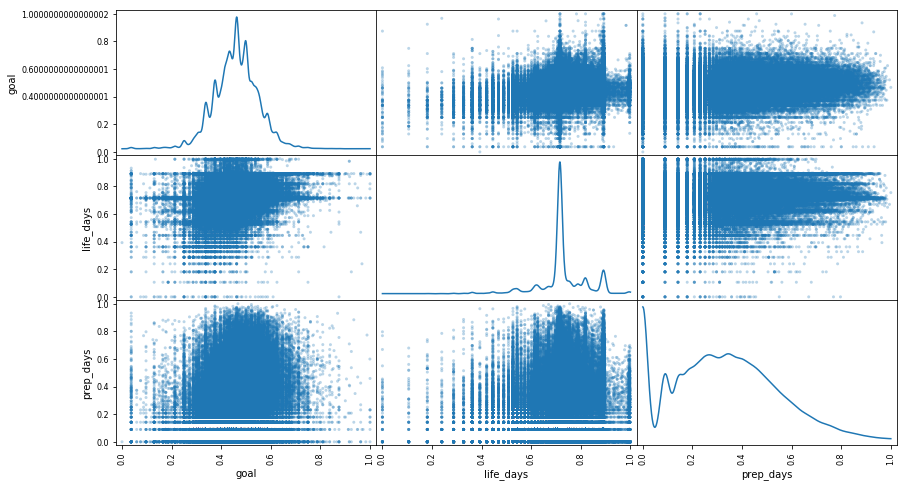

In [93]:
pd.plotting.scatter_matrix(feature, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
feature.corr()

## One-hot-encoding categorical variables

In [137]:
feature_final = pd.get_dummies(feature, columns = CatCol)
feature_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159925 entries, 0 to 159924
Data columns (total 27 columns):
goal                           159925 non-null float64
life_days                      159925 non-null float64
prep_days                      159925 non-null float64
gender_andy                    159925 non-null uint8
gender_female                  159925 non-null uint8
gender_male                    159925 non-null uint8
gender_mostly_female           159925 non-null uint8
gender_mostly_male             159925 non-null uint8
gender_unknown                 159925 non-null uint8
top100_0                       159925 non-null uint8
top100_1                       159925 non-null uint8
top100_99                      159925 non-null uint8
category_broad_art             159925 non-null uint8
category_broad_comics          159925 non-null uint8
category_broad_crafts          159925 non-null uint8
category_broad_dance           159925 non-null uint8
category_broad_design          1599

## Pipeline

In [138]:
# split train-test
from sklearn.cross_validation import train_test_split

# feature_final = feature_final.drop(['category_broad'],axis = 1)

X_train, X_test, y_train, y_test = train_test_split(feature_final,
                                                   target, 
                                                   test_size = 0.2,
                                                   random_state = 23)
print(X_train.shape)
print(X_test.shape)

(127940, 27)
(31985, 27)


In [139]:
from sklearn.metrics import fbeta_score, accuracy_score
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    results = {}
    
    # training
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train_time'] = end - start
    
    # prediction
    
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    results['pred_time'] = end - start
    
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = fbeta_score(y_train[:300], predictions_train,0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
    
    print("{} trained on {} samples. ".format(learner.__class__.__name__, sample_size))

    return results

In [140]:
# naive score
precision = accuracy = np.sum(target)/len(target)

recall = 1
fscore = (1+0.25)*precision*recall/(0.25*precision+recall)

print("Naive Predictor: accuracy: {:.4f}, F:{:.4f}".format(accuracy, fscore))

Naive Predictor: accuracy: 0.5280, F:0.5830


### Training!

In [141]:
# from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import visuals as vs

# clf_S = SVC(random_state = 2)
clf_Logit = LogisticRegression(random_state = 25)
clf_RF = RandomForestClassifier(random_state = 23)

samples_100 = len(y_train)
samples_10 = int(0.1*samples_100)
samples_1 = int(0.01*samples_100)

results = {}
for clf in [clf_Logit, clf_RF]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1,samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)


LogisticRegression trained on 1279 samples. 
LogisticRegression trained on 12794 samples. 
LogisticRegression trained on 127940 samples. 
RandomForestClassifier trained on 1279 samples. 
RandomForestClassifier trained on 12794 samples. 
RandomForestClassifier trained on 127940 samples. 


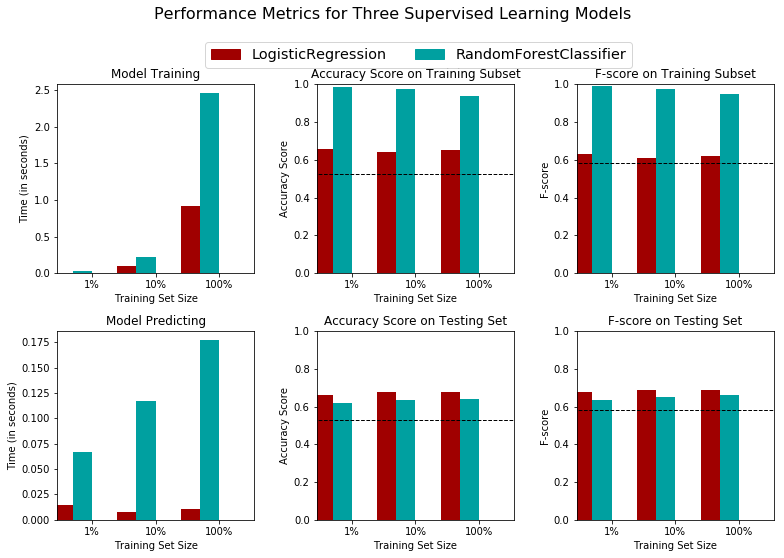

In [142]:
vs.evaluate(results, accuracy, fscore)

### Tuning

In [143]:
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import make_scorer

clf = LogisticRegression(random_state=5)

parameters = {'C':[0.01,0.1,1,10,100,1000],
             'tol':[0.0001,0.001,0.01,0.1]}

scorer = make_scorer(fbeta_score, beta = 0.5)
grid_obj = GridSearchCV(clf, parameters, scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("untuned accuracy:{:.4f}".format(accuracy_score(y_test, predictions)))
print("optimized accuracy:{:.4f}".format(accuracy_score(y_test, best_predictions)))

print("untuned accuracy:{:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("optimized accuracy:{:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


untuned accuracy:0.6753
optimized accuracy:0.6755
untuned accuracy:0.6871
optimized accuracy:0.6872


## Feature Importance

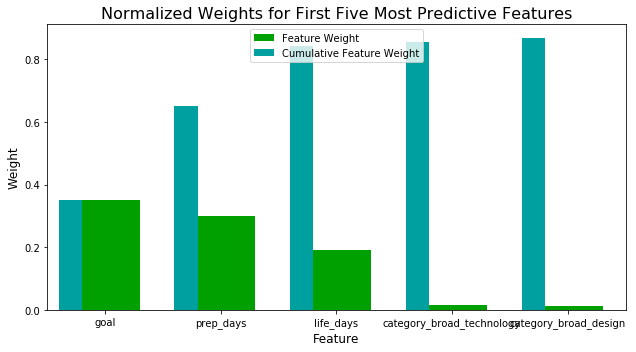

In [144]:
model = RandomForestClassifier(random_state = 40).fit(X_train, y_train)
importances = model.feature_importances_

vs.feature_plot(importances, X_train, y_train)

In [ ]:
# TODO
# categories?
# sentiment